In [16]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [9]:
# Apply label encoder to categorical columns
# Return indices of those columns
def categorical_to_numberic(df):
    cols, indices = [], []
    for i, col in enumerate(df):
        if isinstance(df[col][0], bytes):
            cols.append(col)
            indices.append(i)
    atts = [col for col in df if isinstance(df[col][0], bytes)]
    df[cols] = df[cols].apply(LabelEncoder().fit_transform)
    return indices

In [25]:
# Load arff file into pandas dataframe
data = arff.loadarff("github.arff")
df = pd.DataFrame(data[0])

# Convert categorical data to numeric
cat_cols = categorical_to_numberic(df)

# Randomly sample from the data set
df = df.sample(n=60)

# Impute missing values
df.replace("?", np.NaN, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
idf = pd.DataFrame(imputer.fit_transform(df))
idf.columns = df.columns
idf.index = df.index

# Split off collumn we want to predict
predict_attribute = "contributor_count"
X = idf.drop(predict_attribute, axis=1)
y = idf[predict_attribute]

# Normalize inputs, convert to numpy
X = MinMaxScaler().fit_transform(X)
y = y.to_numpy()

# Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

has_issues  has_projects  has_downloads  has_wiki  has_pages  forks_count  license  has_code_of_conduct  has_contributing  has_pull_request_template  has_deployments  environments_count


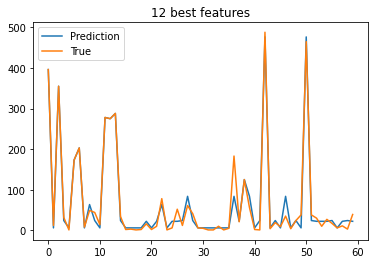

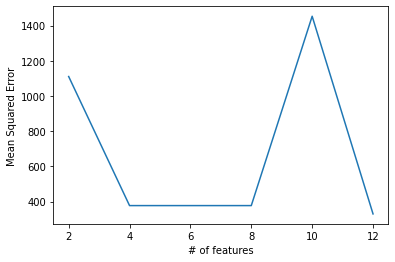

In [26]:
# Sequential feature selection with knn
# Define custom distance metric to handle numeric and categorical data
def my_dist(x, y, cat_cols=[]):
    total = 0
    for i, feature in enumerate(x):
        if i not in cat_cols:
            total += np.abs(feature - y[i])
        elif feature != y[i]:
            total += 0.5
    return total

# regr = KNeighborsRegressor(metric=my_dist, metric_params={"cat_cols": cat_cols})
# regr = MLPRegressor(max_iter=10000)
regr = DecisionTreeRegressor(max_depth=4)
domain = np.arange(2, 13, 2)
n_err = {}
n_pred = {}
n_feats = {}

for i, n in enumerate(domain):
    
    sfs = SequentialFeatureSelector(regr, n_features_to_select=int(n))
    sfs.fit(X, y)
    feats = sfs.get_support()
    n_feats[n] = feats
    X_red = X.T[feats].T
    
    regr.fit(X_red, y)
    pred = regr.predict(X_red)
    n_pred[n] = pred
    err = mean_squared_error(y, pred)
    n_err[n] = err

n_best = min(n_err, key=n_err.get)
pred_best = n_pred[n_best]
print(*[col for col in df.columns[:-1][n_feats[n_best]]], sep="  ")
plt.plot(pred_best, label="Prediction")
plt.plot(y, label="True")
plt.title(f"{n_best} best features")
plt.legend()
plt.show()

plt.plot(domain, n_err.values())
plt.xlabel("# of features")
plt.ylabel("Mean Squared Error")
plt.show()